# train

In [6]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [7]:
from rl_env_inc import TrajComp
from rl_brain import PolicyGradient
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

def run_online(env, RL, ratio, elist): # Validation
    eva = []
    for episode in elist:
        buffer_size = int(ratio*len(env.ori_traj_set[episode]))
        if buffer_size < 3:
            continue
        steps, observation = env.reset(episode, buffer_size)
        for index in range(buffer_size, steps):
            if index == steps - 1:
                done = True
            else:
                done = False
            action = RL.pro_choose_action(observation)
            observation_, _ = env.step(episode, action, index, done, 'V') #'T' means Training, and 'V' means Validation
            observation = observation_
        eva.append(env.output(episode, 'V')) #'T' means Training, 'V' means Validation, and 'V-VIS' for visualization on Validation
    return eva
        
def run_comp(env, RL, Round, traj_amount, valid_amount, show_time, ratio): #Training
    check = 999999
    tra_av_errs = []#放的是每50回合训练集上的平均误差
    val_av_errs = []#放的是每50回合验证集上的平均误差
    for r in range(Round):
        env.shuffle()
        show_time = 50
        episode = 0
        for i in range(0, traj_amount, show_time):
            train_ep_errs = []
            start_t = time.time()
            for _ in tqdm(range(show_time), desc="[{}/{}]".format(min(i+show_time,traj_amount),traj_amount),ncols=100):
                buffer_size = int(ratio*len(env.ori_traj_set[episode]))
                # extreme cases
                if buffer_size < 3:
                    episode += 1
                    continue
                steps, state = env.reset(episode, buffer_size)#初始化状态值，返回轨迹点数和有序列表前k个状态值
                for index in range(buffer_size, steps):#从第一次缓存外第一个点遍历到最后一个点
                    if index == steps - 1:#如果已经是轨迹最后一个点
                        done = True
                    else:
                        done = False
                    action = RL.pro_choose_action(state)#状态输出到神经网络输出动作的概率分布，按概率采样一个动作
                    new_state, reward = env.step(episode, action, index, done, 'T') #'T' means Training, and 'V' means Validation                   
                    RL.store_transition(state, action, reward)
                    if done:
                        RL.learn()#回合结束开始策略梯度算法学习参数
                        break
                    state = new_state
                train_e = env.output(episode, 'T') #'T' means Training, 'V' means Validation, and 'V-VIS' for visualization on Validation
                train_ep_errs.append(train_e)
                episode += 1
            
            val_ep_errs = run_online(env, RL, ratio, [i for i in range(traj_amount, traj_amount + valid_amount)])
            val_av_err = sum(val_ep_errs)/len(val_ep_errs)
            val_av_errs.append(val_av_err)
            tra_av_err = sum(train_ep_errs)/len(train_ep_errs)
            tra_av_errs.append(tra_av_err)
            print('Training error: {}, Validation error: {}'.format(tra_av_err, val_av_err))
            RL.save('./save/'+ str(val_av_err) + '_ratio_' + str(ratio) + '_' + env.label + '/trained_model.ckpt')
            print('Save model at round {} episode {} with error {}'.format(r, episode, val_av_err))
            if val_av_err < check:
                check = val_av_err
            print('==>current best model is {} with ratio {}'.format(check, ratio))
            print('It costs {}s'.format(time.time()-start_t))
    return tra_av_errs, val_av_errs

def train(traj_amount, valid_amount, Round, show_time, ratio, a_size, s_size, label):
    traj_path = '../trajData/Geolife_out/'
    env = TrajComp(a_size, s_size)
    env.load_train_data(traj_path, traj_amount, valid_amount)
    env.set_error_type(label)
    RL = PolicyGradient(env.n_features, env.n_actions)
    start = time.time()
    tra_av_errs, val_av_errs = run_comp(env, RL, Round, traj_amount, valid_amount, show_time, ratio)
    print("Training elapsed time = %s", float(time.time() - start))
    with open('errors_records.txt', 'a') as f:
        f.write('\nTraining errors and validation errors (' + label + ')\n')
        for i in range(len(tra_av_errs)):
            f.write(str(tra_av_errs[i])+' ')
        f.write('\n')
        for i in range(len(val_av_errs)):
            f.write(str(val_av_errs[i])+' ')
    plt.figure()
    plt.title("Average errors of training and validation:")
    plt.xlabel("training process / "+str(show_time)+" episodes")
    plt.ylabel(label+" error")
    x = range(len(tra_av_errs))
    plt.plot(x, tra_av_errs, "r", label="training" )
    plt.plot(x, val_av_errs, "b", label="validation")
    plt.legend()
    plt.figure()
    plt.title("Average errors of validation:")
    plt.xlabel("training process / "+str(show_time)+" episodes")
    plt.ylabel(label+" error")
    x = range(len(tra_av_errs))
    plt.plot(x, val_av_errs, "b", label="validation")
    plt.legend()
    plt.show()



Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.






[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.22s/it]


Training error: 58.5134774781872, Validation error: 48.742662365727455

Save model at round 0 episode 50 with error 48.742662365727455
==>current best model is 48.742662365727455 with ratio 0.1
It costs 195.15287494659424s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:43<00:00,  1.14it/s]


Training error: 310.37377682161224, Validation error: 48.796657603693745
Save model at round 0 episode 100 with error 48.796657603693745
==>current best model is 48.742662365727455 with ratio 0.1
It costs 181.6434280872345s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:15<00:00,  1.50s/it]


Training error: 147.5744630976104, Validation error: 47.96887770947959
Save model at round 0 episode 150 with error 47.96887770947959
==>current best model is 47.96887770947959 with ratio 0.1
It costs 209.27883219718933s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:03<00:00,  1.27s/it]


Training error: 50.46582726075456, Validation error: 49.146246158585676
Save model at round 0 episode 200 with error 49.146246158585676
==>current best model is 47.96887770947959 with ratio 0.1
It costs 197.5473189353943s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:07<00:00,  1.35s/it]


Training error: 62.05683620543593, Validation error: 46.5026897541556
Save model at round 0 episode 250 with error 46.5026897541556
==>current best model is 46.5026897541556 with ratio 0.1
It costs 208.81502771377563s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [02:12<00:00,  2.65s/it]


Training error: 110.29607678958627, Validation error: 49.95467891976686
Save model at round 0 episode 300 with error 49.95467891976686
==>current best model is 46.5026897541556 with ratio 0.1
It costs 270.5283782482147s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:15<00:00,  1.50s/it]


Training error: 83.76473499224565, Validation error: 47.967054644617065
Save model at round 0 episode 350 with error 47.967054644617065
==>current best model is 46.5026897541556 with ratio 0.1
It costs 212.34778928756714s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.15s/it]


Training error: 114.53631310797347, Validation error: 48.0314082634489
Save model at round 0 episode 400 with error 48.0314082634489
==>current best model is 46.5026897541556 with ratio 0.1
It costs 193.73988032341003s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:14<00:00,  1.50s/it]


Training error: 52.293115797309504, Validation error: 48.09565086056552
Save model at round 0 episode 450 with error 48.09565086056552
==>current best model is 46.5026897541556 with ratio 0.1
It costs 209.1981761455536s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:12<00:00,  1.46s/it]


Training error: 79.67417160816963, Validation error: 51.33649824946856
Save model at round 0 episode 500 with error 51.33649824946856
==>current best model is 46.5026897541556 with ratio 0.1
It costs 205.4953010082245s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.17s/it]


Training error: 62.50234587680416, Validation error: 46.26097827917976
Save model at round 1 episode 50 with error 46.26097827917976
==>current best model is 46.26097827917976 with ratio 0.1
It costs 191.24543642997742s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:18<00:00,  1.57s/it]


Training error: 61.274855722313674, Validation error: 46.4178680795517
Save model at round 1 episode 100 with error 46.4178680795517
==>current best model is 46.26097827917976 with ratio 0.1
It costs 210.69804906845093s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [02:16<00:00,  2.73s/it]


Training error: 66.06001265527249, Validation error: 45.98048095928384
Save model at round 1 episode 150 with error 45.98048095928384
==>current best model is 45.98048095928384 with ratio 0.1
It costs 273.8839862346649s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.12s/it]


Training error: 87.63485326748983, Validation error: 48.0904893981789
Save model at round 1 episode 200 with error 48.0904893981789
==>current best model is 45.98048095928384 with ratio 0.1
It costs 188.98633766174316s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:19<00:00,  1.59s/it]


Training error: 46.57384421315192, Validation error: 46.99926814874518
Save model at round 1 episode 250 with error 46.99926814874518
==>current best model is 45.98048095928384 with ratio 0.1
It costs 215.24651312828064s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:26<00:00,  1.72s/it]


Training error: 132.07010467134143, Validation error: 50.988271238393125
Save model at round 1 episode 300 with error 50.988271238393125
==>current best model is 45.98048095928384 with ratio 0.1
It costs 219.5212643146515s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.05s/it]


Training error: 159.00277213910286, Validation error: 47.095772983833776
Save model at round 1 episode 350 with error 47.095772983833776
==>current best model is 45.98048095928384 with ratio 0.1
It costs 191.23678755760193s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:42<00:00,  1.17it/s]


Training error: 293.33387602484174, Validation error: 46.069200038376586
Save model at round 1 episode 400 with error 46.069200038376586
==>current best model is 45.98048095928384 with ratio 0.1
It costs 176.70948791503906s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:30<00:00,  1.80s/it]


Training error: 138.50153689257303, Validation error: 47.230655492303306
Save model at round 1 episode 450 with error 47.230655492303306
==>current best model is 45.98048095928384 with ratio 0.1
It costs 223.2045600414276s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.04s/it]


Training error: 110.37106568964674, Validation error: 47.12399352507431
Save model at round 1 episode 500 with error 47.12399352507431
==>current best model is 45.98048095928384 with ratio 0.1
It costs 185.84680604934692s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:16<00:00,  1.52s/it]


Training error: 75.68428913107925, Validation error: 50.64308173006807
Save model at round 2 episode 50 with error 50.64308173006807
==>current best model is 45.98048095928384 with ratio 0.1
It costs 211.20706129074097s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:25<00:00,  1.70s/it]


Training error: 71.0199750044083, Validation error: 47.66914291088298
Save model at round 2 episode 100 with error 47.66914291088298
==>current best model is 45.98048095928384 with ratio 0.1
It costs 219.48501110076904s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.14s/it]


Training error: 92.05419034692322, Validation error: 48.83600253382337
Save model at round 2 episode 150 with error 48.83600253382337
==>current best model is 45.98048095928384 with ratio 0.1
It costs 191.19150018692017s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:19<00:00,  1.60s/it]


Training error: 65.16137327209107, Validation error: 46.681542973998646
Save model at round 2 episode 200 with error 46.681542973998646
==>current best model is 45.98048095928384 with ratio 0.1
It costs 213.2435278892517s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.19s/it]


Training error: 131.38057996053104, Validation error: 47.575617659504275
Save model at round 2 episode 250 with error 47.575617659504275
==>current best model is 45.98048095928384 with ratio 0.1
It costs 192.76453232765198s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [02:05<00:00,  2.51s/it]


Training error: 70.41563884840996, Validation error: 45.182273611060374
Save model at round 2 episode 300 with error 45.182273611060374
==>current best model is 45.182273611060374 with ratio 0.1
It costs 260.1822335720062s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:20<00:00,  1.62s/it]


Training error: 278.3913652311284, Validation error: 47.386816461667394
Save model at round 2 episode 350 with error 47.386816461667394
==>current best model is 45.182273611060374 with ratio 0.1
It costs 213.4825563430786s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


Training error: 123.04117618968752, Validation error: 48.44618445756712
Save model at round 2 episode 400 with error 48.44618445756712
==>current best model is 45.182273611060374 with ratio 0.1
It costs 182.56466841697693s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.11s/it]


Training error: 99.58430864340262, Validation error: 49.54010162442064
Save model at round 2 episode 450 with error 49.54010162442064
==>current best model is 45.182273611060374 with ratio 0.1
It costs 189.15064978599548s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:05<00:00,  1.31s/it]


Training error: 72.69198868914833, Validation error: 46.651719684401826
Save model at round 2 episode 500 with error 46.651719684401826
==>current best model is 45.182273611060374 with ratio 0.1
It costs 198.74978828430176s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:02<00:00,  1.26s/it]


Training error: 64.95858301700102, Validation error: 45.66846791566766
Save model at round 3 episode 50 with error 45.66846791566766
==>current best model is 45.182273611060374 with ratio 0.1
It costs 200.83693408966064s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:20<00:00,  1.61s/it]


Training error: 55.51474742670979, Validation error: 47.70112054060499
Save model at round 3 episode 100 with error 47.70112054060499
==>current best model is 45.182273611060374 with ratio 0.1
It costs 214.0803244113922s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.06it/s]


Training error: 72.9317868340484, Validation error: 46.6831918280763
Save model at round 3 episode 150 with error 46.6831918280763
==>current best model is 45.182273611060374 with ratio 0.1
It costs 180.83985996246338s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:26<00:00,  1.72s/it]


Training error: 57.052161681197816, Validation error: 48.521002649571344
Save model at round 3 episode 200 with error 48.521002649571344
==>current best model is 45.182273611060374 with ratio 0.1
It costs 220.56480813026428s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.20s/it]


Training error: 40.438367143856084, Validation error: 46.58940071265831
Save model at round 3 episode 250 with error 46.58940071265831
==>current best model is 45.182273611060374 with ratio 0.1
It costs 194.70495653152466s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:25<00:00,  1.71s/it]


Training error: 129.53252093083896, Validation error: 47.98642763150529
Save model at round 3 episode 300 with error 47.98642763150529
==>current best model is 45.182273611060374 with ratio 0.1
It costs 220.23844814300537s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:54<00:00,  2.29s/it]


Training error: 144.25343902027774, Validation error: 44.78383065651714
Save model at round 3 episode 350 with error 44.78383065651714
==>current best model is 44.78383065651714 with ratio 0.1
It costs 248.58034133911133s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:22<00:00,  1.64s/it]


Training error: 111.53475458584319, Validation error: 47.073324429807926
Save model at round 3 episode 400 with error 47.073324429807926
==>current best model is 44.78383065651714 with ratio 0.1
It costs 218.86180520057678s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.02s/it]


Training error: 256.3650919487363, Validation error: 45.5267256436467
Save model at round 3 episode 450 with error 45.5267256436467
==>current best model is 44.78383065651714 with ratio 0.1
It costs 185.82325077056885s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:02<00:00,  1.25s/it]


Training error: 93.54129862603776, Validation error: 45.131747101063475
Save model at round 3 episode 500 with error 45.131747101063475
==>current best model is 44.78383065651714 with ratio 0.1
It costs 196.41554713249207s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:58<00:00,  2.38s/it]


Training error: 168.5608941248185, Validation error: 45.22624791660385
Save model at round 4 episode 50 with error 45.22624791660385
==>current best model is 44.78383065651714 with ratio 0.1
It costs 252.4359610080719s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:27<00:00,  1.74s/it]


Training error: 93.49397194509042, Validation error: 47.6580905178743
Save model at round 4 episode 100 with error 47.6580905178743
==>current best model is 44.78383065651714 with ratio 0.1
It costs 220.0341022014618s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:01<00:00,  1.23s/it]


Training error: 101.2296753619694, Validation error: 45.192223150070134
Save model at round 4 episode 150 with error 45.192223150070134
==>current best model is 44.78383065651714 with ratio 0.1
It costs 195.4457459449768s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:29<00:00,  1.78s/it]


Training error: 64.10579081224974, Validation error: 46.025230431568325
Save model at round 4 episode 200 with error 46.025230431568325
==>current best model is 44.78383065651714 with ratio 0.1
It costs 223.0581784248352s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.16s/it]


Training error: 103.00994316213927, Validation error: 45.7830669828865
Save model at round 4 episode 250 with error 45.7830669828865
==>current best model is 44.78383065651714 with ratio 0.1
It costs 191.05706405639648s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:17<00:00,  1.54s/it]


Training error: 111.49565380365553, Validation error: 46.61028749149647
Save model at round 4 episode 300 with error 46.61028749149647
==>current best model is 44.78383065651714 with ratio 0.1
It costs 210.67827033996582s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:24<00:00,  1.69s/it]


Training error: 63.638506352132346, Validation error: 46.30820241135306
Save model at round 4 episode 350 with error 46.30820241135306
==>current best model is 44.78383065651714 with ratio 0.1
It costs 221.87576031684875s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:45<00:00,  1.10it/s]


Training error: 75.34646368749434, Validation error: 46.634966403380886
Save model at round 4 episode 400 with error 46.634966403380886
==>current best model is 44.78383065651714 with ratio 0.1
It costs 181.5611126422882s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 115.36182268451256, Validation error: 47.22877105390495
Save model at round 4 episode 450 with error 47.22877105390495
==>current best model is 44.78383065651714 with ratio 0.1
It costs 186.5777552127838s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:02<00:00,  1.25s/it]


Training error: 54.3891798377403, Validation error: 52.611439188277856
Save model at round 4 episode 500 with error 52.611439188277856
==>current best model is 44.78383065651714 with ratio 0.1
It costs 195.667582988739s
Training elapsed time = %s 10391.690517663956


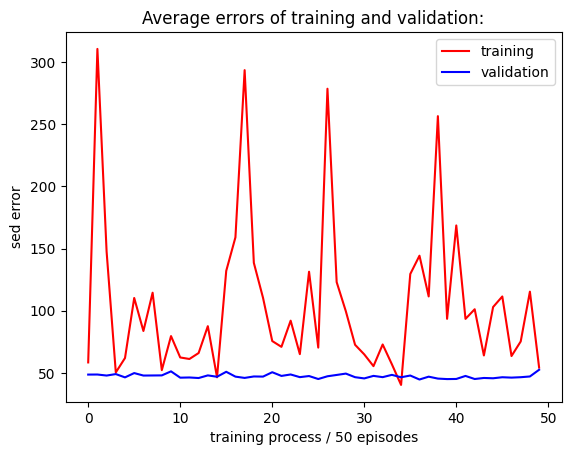

In [3]:
traj_amount = 500
valid_amount = 100
Round = 5
show_time = 50
a_size = 3
s_size = 3
ratio = 0.1 #缓存空间占轨迹大小的比例
label = 'sed'
train(traj_amount, valid_amount, Round, show_time, ratio, a_size, s_size, label)

[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:04<00:00,  1.29s/it]


Training error: 2.0276753279835846, Validation error: 1.8729726798781852
Save model at round 0 episode 50 with error 1.8729726798781852
==>current best model is 1.8729726798781852 with ratio 0.1
It costs 193.90896272659302s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:12<00:00,  1.46s/it]


Training error: 1.8193192106306844, Validation error: 1.8882327732257727
Save model at round 0 episode 100 with error 1.8882327732257727
==>current best model is 1.8729726798781852 with ratio 0.1
It costs 215.69488620758057s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:17<00:00,  1.56s/it]


Training error: 1.8023927397920572, Validation error: 1.8840831214171339
Save model at round 0 episode 150 with error 1.8840831214171339
==>current best model is 1.8729726798781852 with ratio 0.1
It costs 220.5362195968628s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:12<00:00,  1.45s/it]


Training error: 1.988274425550687, Validation error: 1.8922472265404642
Save model at round 0 episode 200 with error 1.8922472265404642
==>current best model is 1.8729726798781852 with ratio 0.1
It costs 213.91578483581543s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:07<00:00,  1.36s/it]


Training error: 1.737724664026432, Validation error: 1.90399758195776
Save model at round 0 episode 250 with error 1.90399758195776
==>current best model is 1.8729726798781852 with ratio 0.1
It costs 197.63827228546143s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:45<00:00,  1.10it/s]


Training error: 1.9990053104215313, Validation error: 1.8991426803028213
Save model at round 0 episode 300 with error 1.8991426803028213
==>current best model is 1.8729726798781852 with ratio 0.1
It costs 170.87389063835144s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:08<00:00,  1.37s/it]


Training error: 1.643627779725291, Validation error: 1.8854019530771344
Save model at round 0 episode 350 with error 1.8854019530771344
==>current best model is 1.8729726798781852 with ratio 0.1
It costs 195.56579852104187s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:08<00:00,  1.38s/it]


Training error: 2.118540158268137, Validation error: 1.8871058336635615
Save model at round 0 episode 400 with error 1.8871058336635615
==>current best model is 1.8729726798781852 with ratio 0.1
It costs 195.8539743423462s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [02:10<00:00,  2.61s/it]


Training error: 1.661441214018786, Validation error: 1.8633937054602914
Save model at round 0 episode 450 with error 1.8633937054602914
==>current best model is 1.8633937054602914 with ratio 0.1
It costs 256.63017296791077s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.00s/it]


Training error: 1.7564138644271698, Validation error: 1.8878936372800181
Save model at round 0 episode 500 with error 1.8878936372800181
==>current best model is 1.8633937054602914 with ratio 0.1
It costs 175.41796207427979s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:24<00:00,  1.70s/it]


Training error: 1.9769419993647817, Validation error: 1.8503397148982095
Save model at round 1 episode 50 with error 1.8503397148982095
==>current best model is 1.8503397148982095 with ratio 0.1
It costs 212.05342268943787s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:24<00:00,  1.68s/it]


Training error: 1.7196039646521941, Validation error: 1.8672382634088833
Save model at round 1 episode 100 with error 1.8672382634088833
==>current best model is 1.8503397148982095 with ratio 0.1
It costs 210.3722665309906s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:20<00:00,  1.61s/it]


Training error: 1.6504537259979981, Validation error: 1.8825250436244216
Save model at round 1 episode 150 with error 1.8825250436244216
==>current best model is 1.8503397148982095 with ratio 0.1
It costs 209.00140810012817s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:05<00:00,  1.31s/it]


Training error: 1.8983319454591128, Validation error: 1.871028354084786
Save model at round 1 episode 200 with error 1.871028354084786
==>current best model is 1.8503397148982095 with ratio 0.1
It costs 193.9537217617035s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:08<00:00,  1.37s/it]


Training error: 2.01649810570899, Validation error: 1.8719025144543955
Save model at round 1 episode 250 with error 1.8719025144543955
==>current best model is 1.8503397148982095 with ratio 0.1
It costs 193.31501173973083s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.04s/it]


Training error: 2.003446324244947, Validation error: 1.8840376190755195
Save model at round 1 episode 300 with error 1.8840376190755195
==>current best model is 1.8503397148982095 with ratio 0.1
It costs 179.45369672775269s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:38<00:00,  1.98s/it]


Training error: 1.718665707221512, Validation error: 1.8797930758231576
Save model at round 1 episode 350 with error 1.8797930758231576
==>current best model is 1.8503397148982095 with ratio 0.1
It costs 224.69743394851685s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


Training error: 1.861811842160145, Validation error: 1.8856293933566786
Save model at round 1 episode 400 with error 1.8856293933566786
==>current best model is 1.8503397148982095 with ratio 0.1
It costs 186.8384392261505s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:46<00:00,  1.07it/s]


Training error: 1.8527692811912895, Validation error: 1.8705964471744598
Save model at round 1 episode 450 with error 1.8705964471744598
==>current best model is 1.8503397148982095 with ratio 0.1
It costs 176.8644940853119s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


Training error: 1.6716321096952351, Validation error: 1.862687634340076
Save model at round 1 episode 500 with error 1.862687634340076
==>current best model is 1.8503397148982095 with ratio 0.1
It costs 176.3038146495819s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:08<00:00,  1.38s/it]


Training error: 1.8184250524979375, Validation error: 1.8685783413871375
Save model at round 2 episode 50 with error 1.8685783413871375
==>current best model is 1.8503397148982095 with ratio 0.1
It costs 193.63300371170044s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 1.877784944453615, Validation error: 1.882749267618968
Save model at round 2 episode 100 with error 1.882749267618968
==>current best model is 1.8503397148982095 with ratio 0.1
It costs 179.82793831825256s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


Training error: 1.7595356663175148, Validation error: 1.8379519265790878
Save model at round 2 episode 150 with error 1.8379519265790878
==>current best model is 1.8379519265790878 with ratio 0.1
It costs 175.46511721611023s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:09<00:00,  1.39s/it]


Training error: 1.8215513774505774, Validation error: 1.8649157604249404
Save model at round 2 episode 200 with error 1.8649157604249404
==>current best model is 1.8379519265790878 with ratio 0.1
It costs 193.97363257408142s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:12<00:00,  1.45s/it]


Training error: 1.7791560463897944, Validation error: 1.8624740603642471
Save model at round 2 episode 250 with error 1.8624740603642471
==>current best model is 1.8379519265790878 with ratio 0.1
It costs 199.19012451171875s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:13<00:00,  1.48s/it]


Training error: 1.7446786176811877, Validation error: 1.8796717754802976
Save model at round 2 episode 300 with error 1.8796717754802976
==>current best model is 1.8379519265790878 with ratio 0.1
It costs 202.96924901008606s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:33<00:00,  1.86s/it]


Training error: 1.698711528752578, Validation error: 1.867499403838822
Save model at round 2 episode 350 with error 1.867499403838822
==>current best model is 1.8379519265790878 with ratio 0.1
It costs 220.543461561203s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:44<00:00,  2.09s/it]


Training error: 2.10608403436183, Validation error: 1.8522253478236024
Save model at round 2 episode 400 with error 1.8522253478236024
==>current best model is 1.8379519265790878 with ratio 0.1
It costs 232.3928771018982s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.16s/it]


Training error: 1.7687087714605674, Validation error: 1.899217501805552
Save model at round 2 episode 450 with error 1.899217501805552
==>current best model is 1.8379519265790878 with ratio 0.1
It costs 183.7480912208557s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


Training error: 1.8748249885786592, Validation error: 1.8733572313276883
Save model at round 2 episode 500 with error 1.8733572313276883
==>current best model is 1.8379519265790878 with ratio 0.1
It costs 179.25778698921204s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.17s/it]


Training error: 1.879549079212748, Validation error: 1.8669952192516837
Save model at round 3 episode 50 with error 1.8669952192516837
==>current best model is 1.8379519265790878 with ratio 0.1
It costs 184.1507134437561s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


Training error: 1.6936241421120242, Validation error: 1.9158301611844812
Save model at round 3 episode 100 with error 1.9158301611844812
==>current best model is 1.8379519265790878 with ratio 0.1
It costs 186.6161243915558s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.16s/it]


Training error: 2.0074969974005485, Validation error: 1.8832367229248863
Save model at round 3 episode 150 with error 1.8832367229248863
==>current best model is 1.8379519265790878 with ratio 0.1
It costs 184.50769710540771s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:15<00:00,  1.51s/it]


Training error: 1.7581252181472664, Validation error: 1.8614724989271598
Save model at round 3 episode 200 with error 1.8614724989271598
==>current best model is 1.8379519265790878 with ratio 0.1
It costs 203.3428599834442s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:38<00:00,  1.97s/it]


Training error: 1.6275967949155277, Validation error: 1.8632976593790673
Save model at round 3 episode 250 with error 1.8632976593790673
==>current best model is 1.8379519265790878 with ratio 0.1
It costs 227.20523953437805s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:35<00:00,  1.41it/s]


Training error: 2.0292455524982422, Validation error: 1.8648201235678536
Save model at round 3 episode 300 with error 1.8648201235678536
==>current best model is 1.8379519265790878 with ratio 0.1
It costs 160.92543053627014s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


Training error: 1.893514947105887, Validation error: 1.867139583246535
Save model at round 3 episode 350 with error 1.867139583246535
==>current best model is 1.8379519265790878 with ratio 0.1
It costs 188.85063219070435s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:08<00:00,  1.37s/it]


Training error: 2.0878797283374904, Validation error: 1.89251502476585
Save model at round 3 episode 400 with error 1.89251502476585
==>current best model is 1.8379519265790878 with ratio 0.1
It costs 196.7636115550995s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:28<00:00,  1.76s/it]


Training error: 1.6202121814061494, Validation error: 1.8617219398961
Save model at round 3 episode 450 with error 1.8617219398961
==>current best model is 1.8379519265790878 with ratio 0.1
It costs 216.42952609062195s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:24<00:00,  1.69s/it]


Training error: 1.6891433959826827, Validation error: 1.8947245362343488
Save model at round 3 episode 500 with error 1.8947245362343488
==>current best model is 1.8379519265790878 with ratio 0.1
It costs 212.92322826385498s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.05s/it]


Training error: 1.6203212298006897, Validation error: 1.8398229422486139
Save model at round 4 episode 50 with error 1.8398229422486139
==>current best model is 1.8379519265790878 with ratio 0.1
It costs 180.88492345809937s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:44<00:00,  1.12it/s]


Training error: 1.5411777923956398, Validation error: 1.8614470695311445
Save model at round 4 episode 100 with error 1.8614470695311445
==>current best model is 1.8379519265790878 with ratio 0.1
It costs 170.41040062904358s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:04<00:00,  1.29s/it]


Training error: 1.748043636274931, Validation error: 1.8460717107990203
Save model at round 4 episode 150 with error 1.8460717107990203
==>current best model is 1.8379519265790878 with ratio 0.1
It costs 190.95652031898499s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.17s/it]


Training error: 2.012261170412418, Validation error: 1.8599134884842365
Save model at round 4 episode 200 with error 1.8599134884842365
==>current best model is 1.8379519265790878 with ratio 0.1
It costs 186.4238724708557s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:49<00:00,  2.19s/it]


Training error: 1.893535821147026, Validation error: 1.8802214695499768
Save model at round 4 episode 250 with error 1.8802214695499768
==>current best model is 1.8379519265790878 with ratio 0.1
It costs 235.11973643302917s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:17<00:00,  1.55s/it]


Training error: 1.9044739098186754, Validation error: 1.8628849697384005
Save model at round 4 episode 300 with error 1.8628849697384005
==>current best model is 1.8379519265790878 with ratio 0.1
It costs 205.0569167137146s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.14s/it]


Training error: 1.9756017699867876, Validation error: 1.8593162310813187
Save model at round 4 episode 350 with error 1.8593162310813187
==>current best model is 1.8379519265790878 with ratio 0.1
It costs 181.65108609199524s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


Training error: 1.8217839423353523, Validation error: 1.8866822498839229
Save model at round 4 episode 400 with error 1.8866822498839229
==>current best model is 1.8379519265790878 with ratio 0.1
It costs 181.21853494644165s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:27<00:00,  1.74s/it]


Training error: 1.8008645779384416, Validation error: 1.8762940887022497
Save model at round 4 episode 450 with error 1.8762940887022497
==>current best model is 1.8379519265790878 with ratio 0.1
It costs 215.0486876964569s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:20<00:00,  1.60s/it]


Training error: 2.0337680744906574, Validation error: 1.8739276974197359
Save model at round 4 episode 500 with error 1.8739276974197359
==>current best model is 1.8379519265790878 with ratio 0.1
It costs 205.91509199142456s
Training elapsed time = %s 9874.293757677078


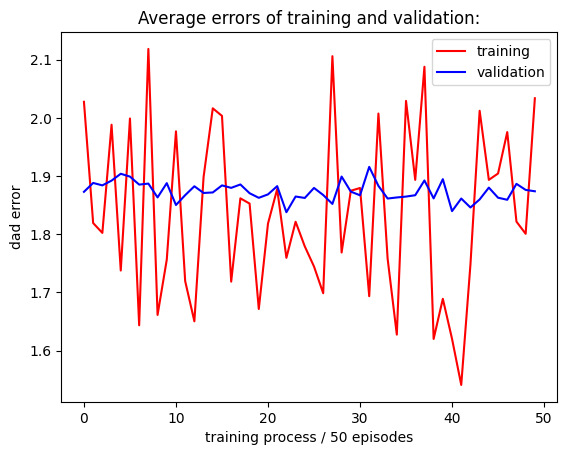

In [4]:
train(traj_amount=500, valid_amount=100, Round=5, show_time=50, ratio=0.1, a_size=3, s_size=3, label='dad')

[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:20<00:00,  1.61s/it]


Training error: 68.4419101183708, Validation error: 25.30050871878492
Save model at round 0 episode 50 with error 25.30050871878492
==>current best model is 25.30050871878492 with ratio 0.1
It costs 211.64984107017517s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:44<00:00,  2.09s/it]


Training error: 32.69170754581004, Validation error: 25.758949467732606
Save model at round 0 episode 100 with error 25.758949467732606
==>current best model is 25.30050871878492 with ratio 0.1
It costs 235.43856692314148s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:21<00:00,  1.64s/it]


Training error: 71.76793131541686, Validation error: 25.91026661832232
Save model at round 0 episode 150 with error 25.91026661832232
==>current best model is 25.30050871878492 with ratio 0.1
It costs 215.2870044708252s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:17<00:00,  1.54s/it]


Training error: 29.13366070896643, Validation error: 26.501113334459465
Save model at round 0 episode 200 with error 26.501113334459465
==>current best model is 25.30050871878492 with ratio 0.1
It costs 220.0977168083191s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Training error: 17.418297166386722, Validation error: 26.85810100620939
Save model at round 0 episode 250 with error 26.85810100620939
==>current best model is 25.30050871878492 with ratio 0.1
It costs 188.13173604011536s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.00it/s]


Training error: 17.976591347399594, Validation error: 25.34384737018689
Save model at round 0 episode 300 with error 25.34384737018689
==>current best model is 25.30050871878492 with ratio 0.1
It costs 193.73526811599731s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.18s/it]


Training error: 139.2993705001439, Validation error: 25.624137751999264
Save model at round 0 episode 350 with error 25.624137751999264
==>current best model is 25.30050871878492 with ratio 0.1
It costs 196.5212082862854s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:24<00:00,  1.70s/it]


Training error: 56.07706763998847, Validation error: 25.138652579322017
Save model at round 0 episode 400 with error 25.138652579322017
==>current best model is 25.138652579322017 with ratio 0.1
It costs 223.55966234207153s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:03<00:00,  1.27s/it]


Training error: 82.91016091791387, Validation error: 27.820191079320416
Save model at round 0 episode 450 with error 27.820191079320416
==>current best model is 25.138652579322017 with ratio 0.1
It costs 188.65275311470032s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.19s/it]


Training error: 59.978152153882974, Validation error: 26.083902220360052
Save model at round 0 episode 500 with error 26.083902220360052
==>current best model is 25.138652579322017 with ratio 0.1
It costs 192.78343057632446s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:18<00:00,  1.56s/it]


Training error: 49.59392513325871, Validation error: 26.811209015538864
Save model at round 1 episode 50 with error 26.811209015538864
==>current best model is 25.138652579322017 with ratio 0.1
It costs 211.84228777885437s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:04<00:00,  1.28s/it]


Training error: 46.476568587572466, Validation error: 27.212482498721002
Save model at round 1 episode 100 with error 27.212482498721002
==>current best model is 25.138652579322017 with ratio 0.1
It costs 198.40944266319275s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:33<00:00,  1.88s/it]


Training error: 22.7247466459034, Validation error: 24.7201556208062
Save model at round 1 episode 150 with error 24.7201556208062
==>current best model is 24.7201556208062 with ratio 0.1
It costs 228.54430055618286s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:13<00:00,  1.47s/it]


Training error: 19.771983015017053, Validation error: 25.86757885228884
Save model at round 1 episode 200 with error 25.86757885228884
==>current best model is 24.7201556208062 with ratio 0.1
It costs 206.8745152950287s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 27.190502223531293, Validation error: 27.501213804061557
Save model at round 1 episode 250 with error 27.501213804061557
==>current best model is 24.7201556208062 with ratio 0.1
It costs 180.53354120254517s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:05<00:00,  1.31s/it]


Training error: 21.949792541147044, Validation error: 22.948062491303343
Save model at round 1 episode 300 with error 22.948062491303343
==>current best model is 22.948062491303343 with ratio 0.1
It costs 198.44439816474915s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:07<00:00,  1.35s/it]


Training error: 224.33453276133292, Validation error: 23.422357171160556
Save model at round 1 episode 350 with error 23.422357171160556
==>current best model is 22.948062491303343 with ratio 0.1
It costs 200.35392355918884s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.04it/s]


Training error: 39.841310801127314, Validation error: 25.52237622395296
Save model at round 1 episode 400 with error 25.52237622395296
==>current best model is 22.948062491303343 with ratio 0.1
It costs 177.42324090003967s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:35<00:00,  1.90s/it]


Training error: 96.29299579047743, Validation error: 25.284541470907552
Save model at round 1 episode 450 with error 25.284541470907552
==>current best model is 22.948062491303343 with ratio 0.1
It costs 225.69009232521057s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:02<00:00,  1.26s/it]


Training error: 92.78424290217187, Validation error: 24.77982388326885
Save model at round 1 episode 500 with error 24.77982388326885
==>current best model is 22.948062491303343 with ratio 0.1
It costs 196.11380553245544s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:42<00:00,  1.17it/s]


Training error: 35.15272610214652, Validation error: 26.76362676837526
Save model at round 2 episode 50 with error 26.76362676837526
==>current best model is 22.948062491303343 with ratio 0.1
It costs 173.51450109481812s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:10<00:00,  1.42s/it]


Training error: 20.89121146194952, Validation error: 24.749892873893018
Save model at round 2 episode 100 with error 24.749892873893018
==>current best model is 22.948062491303343 with ratio 0.1
It costs 200.46073961257935s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:10<00:00,  1.42s/it]


Training error: 277.9664361412698, Validation error: 24.99104904415318
Save model at round 2 episode 150 with error 24.99104904415318
==>current best model is 22.948062491303343 with ratio 0.1
It costs 200.91614961624146s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:28<00:00,  1.76s/it]


Training error: 92.64916278129043, Validation error: 23.994212037577626
Save model at round 2 episode 200 with error 23.994212037577626
==>current best model is 22.948062491303343 with ratio 0.1
It costs 220.2316436767578s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:19<00:00,  1.59s/it]


Training error: 36.39347058594044, Validation error: 23.88961739531586
Save model at round 2 episode 250 with error 23.88961739531586
==>current best model is 22.948062491303343 with ratio 0.1
It costs 212.72558212280273s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:23<00:00,  1.66s/it]


Training error: 18.06212772686045, Validation error: 23.019397012941557
Save model at round 2 episode 300 with error 23.019397012941557
==>current best model is 22.948062491303343 with ratio 0.1
It costs 217.21832156181335s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:36<00:00,  1.37it/s]


Training error: 43.513025753755336, Validation error: 22.624448561539452
Save model at round 2 episode 350 with error 22.624448561539452
==>current best model is 22.624448561539452 with ratio 0.1
It costs 168.03627490997314s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.12s/it]


Training error: 50.32000671216371, Validation error: 24.15532392850176
Save model at round 2 episode 400 with error 24.15532392850176
==>current best model is 22.624448561539452 with ratio 0.1
It costs 189.85388946533203s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [02:06<00:00,  2.53s/it]


Training error: 22.922826852241855, Validation error: 22.274079981388518
Save model at round 2 episode 450 with error 22.274079981388518
==>current best model is 22.274079981388518 with ratio 0.1
It costs 257.14645648002625s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.01s/it]


Training error: 31.20944527382746, Validation error: 23.04490815617517
Save model at round 2 episode 500 with error 23.04490815617517
==>current best model is 22.274079981388518 with ratio 0.1
It costs 179.07919073104858s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:46<00:00,  1.08it/s]


Training error: 39.884297803732274, Validation error: 19.897018875703633
Save model at round 3 episode 50 with error 19.897018875703633
==>current best model is 19.897018875703633 with ratio 0.1
It costs 178.36804842948914s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.03s/it]


Training error: 27.412471257738662, Validation error: 24.710812468064915
Save model at round 3 episode 100 with error 24.710812468064915
==>current best model is 19.897018875703633 with ratio 0.1
It costs 184.0827922821045s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.18s/it]


Training error: 20.21481868644164, Validation error: 21.713841138624712
Save model at round 3 episode 150 with error 21.713841138624712
==>current best model is 19.897018875703633 with ratio 0.1
It costs 192.53304529190063s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:43<00:00,  2.07s/it]


Training error: 58.203868561353566, Validation error: 23.97955382824845
Save model at round 3 episode 200 with error 23.97955382824845
==>current best model is 19.897018875703633 with ratio 0.1
It costs 238.67686367034912s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:38<00:00,  1.97s/it]


Training error: 44.04614836482629, Validation error: 19.28055979818691
Save model at round 3 episode 250 with error 19.28055979818691
==>current best model is 19.28055979818691 with ratio 0.1
It costs 230.55964398384094s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:49<00:00,  2.20s/it]


Training error: 127.1960729893734, Validation error: 19.873258818489827
Save model at round 3 episode 300 with error 19.873258818489827
==>current best model is 19.28055979818691 with ratio 0.1
It costs 243.1051528453827s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:03<00:00,  1.27s/it]


Training error: 60.689758981883585, Validation error: 23.412267329395867
Save model at round 3 episode 350 with error 23.412267329395867
==>current best model is 19.28055979818691 with ratio 0.1
It costs 198.98481464385986s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.03s/it]


Training error: 34.497146976524995, Validation error: 20.65217772599962
Save model at round 3 episode 400 with error 20.65217772599962
==>current best model is 19.28055979818691 with ratio 0.1
It costs 190.33666729927063s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.11s/it]


Training error: 24.31485635525948, Validation error: 20.1089455917858
Save model at round 3 episode 450 with error 20.1089455917858
==>current best model is 19.28055979818691 with ratio 0.1
It costs 191.2105553150177s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:06<00:00,  1.33s/it]


Training error: 19.93514650331506, Validation error: 20.335517353363425
Save model at round 3 episode 500 with error 20.335517353363425
==>current best model is 19.28055979818691 with ratio 0.1
It costs 193.2933373451233s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:17<00:00,  1.55s/it]


Training error: 116.02917902611325, Validation error: 20.407694470888096
Save model at round 4 episode 50 with error 20.407694470888096
==>current best model is 19.28055979818691 with ratio 0.1
It costs 210.57074213027954s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.20s/it]


Training error: 33.13165098331896, Validation error: 19.944771800221233
Save model at round 4 episode 100 with error 19.944771800221233
==>current best model is 19.28055979818691 with ratio 0.1
It costs 191.41883373260498s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:07<00:00,  1.34s/it]


Training error: 35.847621679146066, Validation error: 20.30279102812632
Save model at round 4 episode 150 with error 20.30279102812632
==>current best model is 19.28055979818691 with ratio 0.1
It costs 199.3998522758484s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:19<00:00,  1.59s/it]


Training error: 89.48470628736888, Validation error: 20.787994099810692
Save model at round 4 episode 200 with error 20.787994099810692
==>current best model is 19.28055979818691 with ratio 0.1
It costs 215.72267818450928s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:11<00:00,  1.43s/it]


Training error: 29.41049097411058, Validation error: 21.158638426756053
Save model at round 4 episode 250 with error 21.158638426756053
==>current best model is 19.28055979818691 with ratio 0.1
It costs 206.6310179233551s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:43<00:00,  1.15it/s]


Training error: 14.492138708062193, Validation error: 20.43991664364977
Save model at round 4 episode 300 with error 20.43991664364977
==>current best model is 19.28055979818691 with ratio 0.1
It costs 172.92293310165405s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:58<00:00,  1.17s/it]


Training error: 45.44762147923422, Validation error: 19.988164167322893
Save model at round 4 episode 350 with error 19.988164167322893
==>current best model is 19.28055979818691 with ratio 0.1
It costs 188.30736374855042s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:01<00:00,  1.24s/it]


Training error: 20.97118358955928, Validation error: 17.57928306848788
Save model at round 4 episode 400 with error 17.57928306848788
==>current best model is 17.57928306848788 with ratio 0.1
It costs 188.48131656646729s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.00it/s]


Training error: 55.46455971949886, Validation error: 19.577988296592896
Save model at round 4 episode 450 with error 19.577988296592896
==>current best model is 17.57928306848788 with ratio 0.1
It costs 178.81605505943298s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [02:07<00:00,  2.54s/it]


Training error: 32.78738308287311, Validation error: 20.428249256087444
Save model at round 4 episode 500 with error 20.428249256087444
==>current best model is 17.57928306848788 with ratio 0.1
It costs 257.53686714172363s
Training elapsed time = %s 10160.23181605339


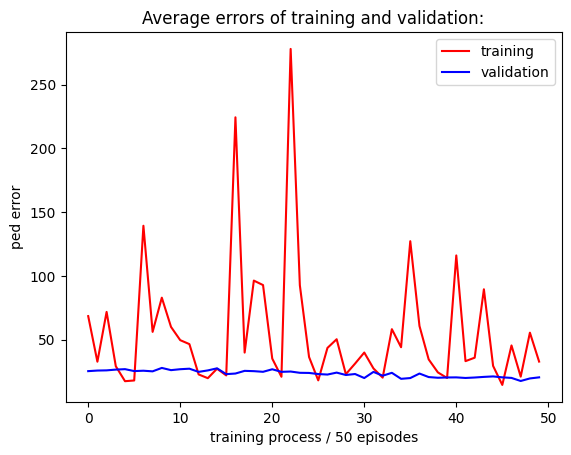

In [14]:
train(traj_amount=500, valid_amount=100, Round=5, show_time=50, ratio=0.1, a_size=3, s_size=3, label='ped')


Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.






[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:01<00:00,  1.24s/it]


Training error: 7.373106837003853, Validation error: 6.71273141708931

Save model at round 0 episode 50 with error 6.71273141708931
==>current best model is 6.71273141708931 with ratio 0.1
It costs 211.13239002227783s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:22<00:00,  1.66s/it]


Training error: 6.557867046010081, Validation error: 6.846242641751043
Save model at round 0 episode 100 with error 6.846242641751043
==>current best model is 6.71273141708931 with ratio 0.1
It costs 239.86184239387512s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:14<00:00,  1.50s/it]


Training error: 8.947868721288883, Validation error: 6.871055198036188
Save model at round 0 episode 150 with error 6.871055198036188
==>current best model is 6.71273141708931 with ratio 0.1
It costs 232.37991905212402s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:09<00:00,  1.39s/it]


Training error: 8.210695387426904, Validation error: 7.094568118913412
Save model at round 0 episode 200 with error 7.094568118913412
==>current best model is 6.71273141708931 with ratio 0.1
It costs 233.1930434703827s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:17<00:00,  1.54s/it]


Training error: 6.746423285103515, Validation error: 7.137882959278576
Save model at round 0 episode 250 with error 7.137882959278576
==>current best model is 6.71273141708931 with ratio 0.1
It costs 242.7706003189087s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [02:10<00:00,  2.62s/it]


Training error: 7.215959686190274, Validation error: 6.972739969018777
Save model at round 0 episode 300 with error 6.972739969018777
==>current best model is 6.71273141708931 with ratio 0.1
It costs 281.0292375087738s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [02:16<00:00,  2.74s/it]


Training error: 6.128822935239968, Validation error: 6.916912816338249
Save model at round 0 episode 350 with error 6.916912816338249
==>current best model is 6.71273141708931 with ratio 0.1
It costs 292.63999366760254s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [02:20<00:00,  2.80s/it]


Training error: 6.709402683065868, Validation error: 6.7239722161819175
Save model at round 0 episode 400 with error 6.7239722161819175
==>current best model is 6.71273141708931 with ratio 0.1
It costs 296.6715247631073s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:20<00:00,  1.62s/it]


Training error: 7.63633039096926, Validation error: 6.910610199942297
Save model at round 0 episode 450 with error 6.910610199942297
==>current best model is 6.71273141708931 with ratio 0.1
It costs 233.40911030769348s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:13<00:00,  1.47s/it]


Training error: 7.075503269299394, Validation error: 7.041780111432631
Save model at round 0 episode 500 with error 7.041780111432631
==>current best model is 6.71273141708931 with ratio 0.1
It costs 223.0682442188263s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [02:08<00:00,  2.56s/it]


Training error: 7.028294224423175, Validation error: 7.022398483417982
Save model at round 1 episode 50 with error 7.022398483417982
==>current best model is 6.71273141708931 with ratio 0.1
It costs 278.7114427089691s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:49<00:00,  2.19s/it]


Training error: 6.252497834490044, Validation error: 6.885780407551389
Save model at round 1 episode 100 with error 6.885780407551389
==>current best model is 6.71273141708931 with ratio 0.1
It costs 261.98435282707214s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.03s/it]


Training error: 8.991308043442888, Validation error: 7.0385271477996945
Save model at round 1 episode 150 with error 7.0385271477996945
==>current best model is 6.71273141708931 with ratio 0.1
It costs 200.7400143146515s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:50<00:00,  2.20s/it]


Training error: 6.919568408965996, Validation error: 7.006579958857577
Save model at round 1 episode 200 with error 7.006579958857577
==>current best model is 6.71273141708931 with ratio 0.1
It costs 259.9315083026886s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:06<00:00,  1.34s/it]


Training error: 6.653786367781619, Validation error: 6.918900399274585
Save model at round 1 episode 250 with error 6.918900399274585
==>current best model is 6.71273141708931 with ratio 0.1
It costs 217.20485496520996s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:26<00:00,  1.73s/it]


Training error: 8.26650216153839, Validation error: 6.904921285361235
Save model at round 1 episode 300 with error 6.904921285361235
==>current best model is 6.71273141708931 with ratio 0.1
It costs 239.23827290534973s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:55<00:00,  2.32s/it]


Training error: 6.8315776990121595, Validation error: 6.879806474743582
Save model at round 1 episode 350 with error 6.879806474743582
==>current best model is 6.71273141708931 with ratio 0.1
It costs 266.7507154941559s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:35<00:00,  1.92s/it]


Training error: 6.9660362349729725, Validation error: 6.850482036472409
Save model at round 1 episode 400 with error 6.850482036472409
==>current best model is 6.71273141708931 with ratio 0.1
It costs 246.14229226112366s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:10<00:00,  1.41s/it]


Training error: 8.055592016513199, Validation error: 7.079884299811067
Save model at round 1 episode 450 with error 7.079884299811067
==>current best model is 6.71273141708931 with ratio 0.1
It costs 221.16968154907227s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:10<00:00,  1.41s/it]


Training error: 6.399819720596123, Validation error: 7.000678472543983
Save model at round 1 episode 500 with error 7.000678472543983
==>current best model is 6.71273141708931 with ratio 0.1
It costs 225.2477355003357s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:15<00:00,  1.51s/it]


Training error: 7.175490811845667, Validation error: 6.928528081323879
Save model at round 2 episode 50 with error 6.928528081323879
==>current best model is 6.71273141708931 with ratio 0.1
It costs 239.87876868247986s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:39<00:00,  1.99s/it]


Training error: 6.681148883331855, Validation error: 6.767774532259492
Save model at round 2 episode 100 with error 6.767774532259492
==>current best model is 6.71273141708931 with ratio 0.1
It costs 253.18660473823547s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:53<00:00,  2.27s/it]


Training error: 5.644184578981126, Validation error: 7.135677578969879
Save model at round 2 episode 150 with error 7.135677578969879
==>current best model is 6.71273141708931 with ratio 0.1
It costs 272.20181345939636s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [02:38<00:00,  3.16s/it]


Training error: 7.939857321010738, Validation error: 6.7484886802752815
Save model at round 2 episode 200 with error 6.7484886802752815
==>current best model is 6.71273141708931 with ratio 0.1
It costs 314.1868097782135s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:36<00:00,  1.94s/it]


Training error: 7.179580504732059, Validation error: 6.9623115628767165
Save model at round 2 episode 250 with error 6.9623115628767165
==>current best model is 6.71273141708931 with ratio 0.1
It costs 255.9970407485962s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:08<00:00,  1.37s/it]


Training error: 7.569376684333497, Validation error: 6.7996741716060765
Save model at round 2 episode 300 with error 6.7996741716060765
==>current best model is 6.71273141708931 with ratio 0.1
It costs 225.88571190834045s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:31<00:00,  1.84s/it]


Training error: 8.03862089746349, Validation error: 6.918203420009226
Save model at round 2 episode 350 with error 6.918203420009226
==>current best model is 6.71273141708931 with ratio 0.1
It costs 244.3841474056244s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:06<00:00,  1.33s/it]


Training error: 6.64054518664927, Validation error: 6.972103236967223
Save model at round 2 episode 400 with error 6.972103236967223
==>current best model is 6.71273141708931 with ratio 0.1
It costs 218.43322896957397s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:13<00:00,  1.47s/it]


Training error: 7.736151503763061, Validation error: 6.9732293344245235
Save model at round 2 episode 450 with error 6.9732293344245235
==>current best model is 6.71273141708931 with ratio 0.1
It costs 224.65032172203064s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:32<00:00,  1.85s/it]


Training error: 7.812592366908729, Validation error: 7.126014495500204
Save model at round 2 episode 500 with error 7.126014495500204
==>current best model is 6.71273141708931 with ratio 0.1
It costs 244.666335105896s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [01:13<00:00,  1.47s/it]


Training error: 6.462094734090051, Validation error: 6.868143174969606
Save model at round 3 episode 50 with error 6.868143174969606
==>current best model is 6.71273141708931 with ratio 0.1
It costs 233.13646245002747s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:32<00:00,  1.86s/it]


Training error: 8.164555987491779, Validation error: 6.870583256868506
Save model at round 3 episode 100 with error 6.870583256868506
==>current best model is 6.71273141708931 with ratio 0.1
It costs 244.75868368148804s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:16<00:00,  1.53s/it]


Training error: 8.237558371117894, Validation error: 6.928022480871108
Save model at round 3 episode 150 with error 6.928022480871108
==>current best model is 6.71273141708931 with ratio 0.1
It costs 229.13703894615173s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.13s/it]


Training error: 7.008511317766618, Validation error: 6.990832706226029
Save model at round 3 episode 200 with error 6.990832706226029
==>current best model is 6.71273141708931 with ratio 0.1
It costs 207.2340223789215s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:16<00:00,  1.53s/it]


Training error: 6.289642437805464, Validation error: 7.003966203897815
Save model at round 3 episode 250 with error 7.003966203897815
==>current best model is 6.71273141708931 with ratio 0.1
It costs 227.78341555595398s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.13s/it]


Training error: 6.509064031514421, Validation error: 6.846984107910296
Save model at round 3 episode 300 with error 6.846984107910296
==>current best model is 6.71273141708931 with ratio 0.1
It costs 207.85618948936462s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:51<00:00,  2.22s/it]


Training error: 6.4234457449089435, Validation error: 6.872095150434288
Save model at round 3 episode 350 with error 6.872095150434288
==>current best model is 6.71273141708931 with ratio 0.1
It costs 262.2632751464844s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [02:24<00:00,  2.88s/it]


Training error: 8.11711367262833, Validation error: 6.884289976846641
Save model at round 3 episode 400 with error 6.884289976846641
==>current best model is 6.71273141708931 with ratio 0.1
It costs 297.3659973144531s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:57<00:00,  2.34s/it]


Training error: 8.28128682557769, Validation error: 6.882690196423535
Save model at round 3 episode 450 with error 6.882690196423535
==>current best model is 6.71273141708931 with ratio 0.1
It costs 272.0281000137329s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:41<00:00,  2.03s/it]


Training error: 6.479773148688373, Validation error: 6.878232378788629
Save model at round 3 episode 500 with error 6.878232378788629
==>current best model is 6.71273141708931 with ratio 0.1
It costs 253.33700561523438s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [02:50<00:00,  3.42s/it]


Training error: 7.182757023282724, Validation error: 6.977244380712725
Save model at round 4 episode 50 with error 6.977244380712725
==>current best model is 6.71273141708931 with ratio 0.1
It costs 322.2803406715393s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:24<00:00,  1.70s/it]


Training error: 7.087170958097448, Validation error: 6.94777314422968
Save model at round 4 episode 100 with error 6.94777314422968
==>current best model is 6.71273141708931 with ratio 0.1
It costs 235.99952697753906s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:31<00:00,  1.83s/it]


Training error: 7.238857504203993, Validation error: 6.9983878153274395
Save model at round 4 episode 150 with error 6.9983878153274395
==>current best model is 6.71273141708931 with ratio 0.1
It costs 241.23701071739197s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:06<00:00,  1.34s/it]


Training error: 7.600150224011211, Validation error: 6.867636689351974
Save model at round 4 episode 200 with error 6.867636689351974
==>current best model is 6.71273141708931 with ratio 0.1
It costs 216.52403497695923s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:16<00:00,  1.54s/it]


Training error: 6.694663144724923, Validation error: 6.816091576750583
Save model at round 4 episode 250 with error 6.816091576750583
==>current best model is 6.71273141708931 with ratio 0.1
It costs 226.43045496940613s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:40<00:00,  2.02s/it]


Training error: 7.091394093414847, Validation error: 6.803245980694133
Save model at round 4 episode 300 with error 6.803245980694133
==>current best model is 6.71273141708931 with ratio 0.1
It costs 251.35330653190613s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.01s/it]


Training error: 7.716778639975596, Validation error: 6.987533975871664
Save model at round 4 episode 350 with error 6.987533975871664
==>current best model is 6.71273141708931 with ratio 0.1
It costs 210.95123386383057s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:21<00:00,  1.63s/it]


Training error: 7.311033730017381, Validation error: 7.066379726605626
Save model at round 4 episode 400 with error 7.066379726605626
==>current best model is 6.71273141708931 with ratio 0.1
It costs 229.7643187046051s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:41<00:00,  2.03s/it]


Training error: 6.059303128274344, Validation error: 6.966948576253211
Save model at round 4 episode 450 with error 6.966948576253211
==>current best model is 6.71273141708931 with ratio 0.1
It costs 250.9044327735901s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:16<00:00,  1.53s/it]


Training error: 8.163943338214505, Validation error: 6.940615271853276
Save model at round 4 episode 500 with error 6.940615271853276
==>current best model is 6.71273141708931 with ratio 0.1
It costs 224.86088228225708s
Training elapsed time = %s 12241.958669662476


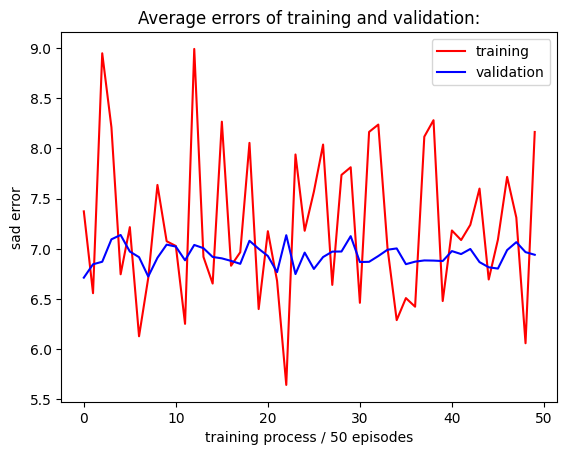

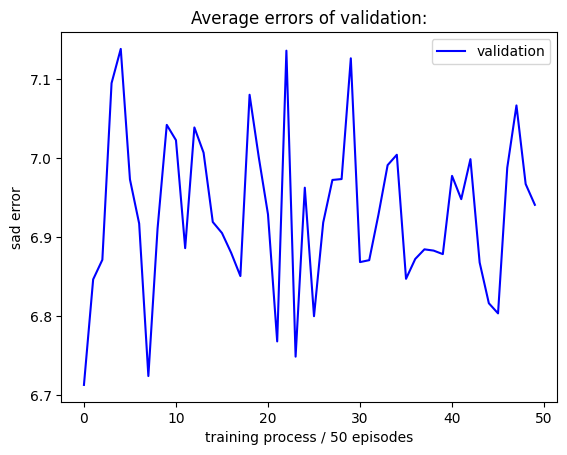

In [3]:
train(traj_amount=500, valid_amount=100, Round=5, show_time=50, ratio=0.1, a_size=3, s_size=3, label='sad')


Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.






[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:42<00:00,  1.19it/s]


Training error: 5.798538131198837, Validation error: 3.463997339920368

Save model at round 0 episode 50 with error 3.463997339920368
==>current best model is 3.463997339920368 with ratio 0.5
It costs 121.19610404968262s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.11s/it]


Training error: 9.225340427999036, Validation error: 3.488847105021951
Save model at round 0 episode 100 with error 3.488847105021951
==>current best model is 3.463997339920368 with ratio 0.5
It costs 133.05427289009094s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:36<00:00,  1.36it/s]


Training error: 4.090810232921926, Validation error: 3.6304785410865126
Save model at round 0 episode 150 with error 3.6304785410865126
==>current best model is 3.463997339920368 with ratio 0.5
It costs 112.9334044456482s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:46<00:00,  1.07it/s]


Training error: 2.7527676812504867, Validation error: 3.5431980338657705
Save model at round 0 episode 200 with error 3.5431980338657705
==>current best model is 3.463997339920368 with ratio 0.5
It costs 123.64990305900574s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.53it/s]


Training error: 6.827828343151102, Validation error: 3.404171115894671
Save model at round 0 episode 250 with error 3.404171115894671
==>current best model is 3.404171115894671 with ratio 0.5
It costs 111.56382298469543s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.71it/s]


Training error: 4.3748367866573545, Validation error: 3.436519113207166
Save model at round 0 episode 300 with error 3.436519113207166
==>current best model is 3.404171115894671 with ratio 0.5
It costs 106.92164540290833s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.74it/s]


Training error: 4.39049739314758, Validation error: 3.373529431078536
Save model at round 0 episode 350 with error 3.373529431078536
==>current best model is 3.373529431078536 with ratio 0.5
It costs 106.65807390213013s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:42<00:00,  1.17it/s]


Training error: 3.3844809944344587, Validation error: 3.430546784407556
Save model at round 0 episode 400 with error 3.430546784407556
==>current best model is 3.373529431078536 with ratio 0.5
It costs 120.16298627853394s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.05s/it]


Training error: 6.7431237427930215, Validation error: 3.378343905754111
Save model at round 0 episode 450 with error 3.378343905754111
==>current best model is 3.373529431078536 with ratio 0.5
It costs 131.57593250274658s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:46<00:00,  1.08it/s]


Training error: 8.495972555371498, Validation error: 3.448556186052195
Save model at round 0 episode 500 with error 3.448556186052195
==>current best model is 3.373529431078536 with ratio 0.5
It costs 120.9652726650238s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:35<00:00,  1.41it/s]


Training error: 4.204559789032112, Validation error: 3.3453462006094816
Save model at round 1 episode 50 with error 3.3453462006094816
==>current best model is 3.3453462006094816 with ratio 0.5
It costs 112.04142475128174s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


Training error: 3.3792083565832867, Validation error: 3.358532702198013
Save model at round 1 episode 100 with error 3.358532702198013
==>current best model is 3.3453462006094816 with ratio 0.5
It costs 115.85392761230469s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:42<00:00,  1.18it/s]


Training error: 10.254187603593296, Validation error: 3.333356347234221
Save model at round 1 episode 150 with error 3.333356347234221
==>current best model is 3.333356347234221 with ratio 0.5
It costs 117.51717877388s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:39<00:00,  1.26it/s]


Training error: 5.637959493354435, Validation error: 3.4248280386900674
Save model at round 1 episode 200 with error 3.4248280386900674
==>current best model is 3.333356347234221 with ratio 0.5
It costs 114.71559357643127s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.43it/s]


Training error: 4.183783723304843, Validation error: 3.2560721618371615
Save model at round 1 episode 250 with error 3.2560721618371615
==>current best model is 3.2560721618371615 with ratio 0.5
It costs 110.31904888153076s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:41<00:00,  1.22it/s]


Training error: 3.8735679510371717, Validation error: 3.3620658229802816
Save model at round 1 episode 300 with error 3.3620658229802816
==>current best model is 3.2560721618371615 with ratio 0.5
It costs 116.89212822914124s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:39<00:00,  1.26it/s]


Training error: 6.376174321571342, Validation error: 3.2938410592413394
Save model at round 1 episode 350 with error 3.2938410592413394
==>current best model is 3.2560721618371615 with ratio 0.5
It costs 118.4013659954071s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:51<00:00,  1.04s/it]


Training error: 2.9217793674486745, Validation error: 3.3382898051302794
Save model at round 1 episode 400 with error 3.3382898051302794
==>current best model is 3.2560721618371615 with ratio 0.5
It costs 131.64141416549683s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Training error: 7.384818807339266, Validation error: 3.3164061909983396
Save model at round 1 episode 450 with error 3.3164061909983396
==>current best model is 3.2560721618371615 with ratio 0.5
It costs 110.75248622894287s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.13s/it]


Training error: 5.030267044286777, Validation error: 3.340457760980521
Save model at round 1 episode 500 with error 3.340457760980521
==>current best model is 3.2560721618371615 with ratio 0.5
It costs 139.98946905136108s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.51it/s]


Training error: 5.101241073004798, Validation error: 3.4006602352171726
Save model at round 2 episode 50 with error 3.4006602352171726
==>current best model is 3.2560721618371615 with ratio 0.5
It costs 111.31276822090149s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:07<00:00,  1.36s/it]


Training error: 5.456871402045007, Validation error: 3.300734123609974
Save model at round 2 episode 100 with error 3.300734123609974
==>current best model is 3.2560721618371615 with ratio 0.5
It costs 147.8392312526703s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.53it/s]


Training error: 4.619544451048923, Validation error: 3.252484098102047
Save model at round 2 episode 150 with error 3.252484098102047
==>current best model is 3.252484098102047 with ratio 0.5
It costs 108.04850029945374s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:41<00:00,  1.20it/s]


Training error: 4.086216091036643, Validation error: 3.2828617430277776
Save model at round 2 episode 200 with error 3.2828617430277776
==>current best model is 3.252484098102047 with ratio 0.5
It costs 120.34149885177612s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:36<00:00,  1.38it/s]


Training error: 5.173512826254487, Validation error: 3.3976749899819008
Save model at round 2 episode 250 with error 3.3976749899819008
==>current best model is 3.252484098102047 with ratio 0.5
It costs 112.60279512405396s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.46it/s]


Training error: 8.719729496467409, Validation error: 3.242463056048615
Save model at round 2 episode 300 with error 3.242463056048615
==>current best model is 3.242463056048615 with ratio 0.5
It costs 112.51060366630554s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.02it/s]


Training error: 4.108621837319675, Validation error: 3.234878536308276
Save model at round 2 episode 350 with error 3.234878536308276
==>current best model is 3.234878536308276 with ratio 0.5
It costs 125.81203246116638s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:36<00:00,  1.36it/s]


Training error: 3.383135841162367, Validation error: 3.3134744159159646
Save model at round 2 episode 400 with error 3.3134744159159646
==>current best model is 3.234878536308276 with ratio 0.5
It costs 113.7095115184784s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


Training error: 4.900381976195947, Validation error: 3.276327300441994
Save model at round 2 episode 450 with error 3.276327300441994
==>current best model is 3.234878536308276 with ratio 0.5
It costs 124.70484185218811s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.56it/s]


Training error: 7.0888984180139, Validation error: 3.285598583545304
Save model at round 2 episode 500 with error 3.285598583545304
==>current best model is 3.234878536308276 with ratio 0.5
It costs 110.9889178276062s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:38<00:00,  1.28it/s]


Training error: 5.496388633629437, Validation error: 3.271323304517544
Save model at round 3 episode 50 with error 3.271323304517544
==>current best model is 3.234878536308276 with ratio 0.5
It costs 115.63318586349487s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Training error: 3.5177017363432896, Validation error: 3.3225982542989634
Save model at round 3 episode 100 with error 3.3225982542989634
==>current best model is 3.234878536308276 with ratio 0.5
It costs 108.94419980049133s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.96it/s]


Training error: 5.19909155949909, Validation error: 3.360002965243953
Save model at round 3 episode 150 with error 3.360002965243953
==>current best model is 3.234878536308276 with ratio 0.5
It costs 103.48303079605103s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.04s/it]


Training error: 9.233072068736051, Validation error: 3.2400461498932964
Save model at round 3 episode 200 with error 3.2400461498932964
==>current best model is 3.234878536308276 with ratio 0.5
It costs 128.43144392967224s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:23<00:00,  2.12it/s]


Training error: 5.084619646027465, Validation error: 3.2201045303144102
Save model at round 3 episode 250 with error 3.2201045303144102
==>current best model is 3.2201045303144102 with ratio 0.5
It costs 103.84913301467896s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:41<00:00,  1.21it/s]


Training error: 8.463430965068904, Validation error: 3.1413287502919656
Save model at round 3 episode 300 with error 3.1413287502919656
==>current best model is 3.1413287502919656 with ratio 0.5
It costs 122.66416835784912s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:42<00:00,  1.19it/s]


Training error: 3.097832664475383, Validation error: 3.141976323548464
Save model at round 3 episode 350 with error 3.141976323548464
==>current best model is 3.1413287502919656 with ratio 0.5
It costs 120.87062621116638s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:01<00:00,  1.23s/it]


Training error: 3.329140331043447, Validation error: 3.171637409382404
Save model at round 3 episode 400 with error 3.171637409382404
==>current best model is 3.1413287502919656 with ratio 0.5
It costs 142.54670977592468s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.14s/it]


Training error: 3.910739263983711, Validation error: 3.1717911474517084
Save model at round 3 episode 450 with error 3.1717911474517084
==>current best model is 3.1413287502919656 with ratio 0.5
It costs 139.98836708068848s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Training error: 5.607071306432371, Validation error: 3.200409170267433
Save model at round 3 episode 500 with error 3.200409170267433
==>current best model is 3.1413287502919656 with ratio 0.5
It costs 129.10672330856323s


[50/500]: 100%|█████████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.62it/s]


Training error: 6.101840027306839, Validation error: 3.160536038304398
Save model at round 4 episode 50 with error 3.160536038304398
==>current best model is 3.1413287502919656 with ratio 0.5
It costs 94.54505276679993s


[100/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.63it/s]


Training error: 6.876515292790705, Validation error: 3.1730435272264783
Save model at round 4 episode 100 with error 3.1730435272264783
==>current best model is 3.1413287502919656 with ratio 0.5
It costs 105.9429361820221s


[150/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.09s/it]


Training error: 3.133511861420479, Validation error: 3.216615401334693
Save model at round 4 episode 150 with error 3.216615401334693
==>current best model is 3.1413287502919656 with ratio 0.5
It costs 130.16742086410522s


[200/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.43it/s]


Training error: 6.05244585273443, Validation error: 3.1648408716212533
Save model at round 4 episode 200 with error 3.1648408716212533
==>current best model is 3.1413287502919656 with ratio 0.5
It costs 112.6907708644867s


[250/500]: 100%|████████████████████████████████████████████████████| 50/50 [01:07<00:00,  1.35s/it]


Training error: 4.150545038365769, Validation error: 3.202380036352902
Save model at round 4 episode 250 with error 3.202380036352902
==>current best model is 3.1413287502919656 with ratio 0.5
It costs 142.8453392982483s


[300/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.03it/s]


Training error: 2.9457566314381047, Validation error: 3.1703036848236583
Save model at round 4 episode 300 with error 3.1703036848236583
==>current best model is 3.1413287502919656 with ratio 0.5
It costs 125.40916991233826s


[350/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:42<00:00,  1.18it/s]


Training error: 5.372816216053318, Validation error: 3.0932506440185987
Save model at round 4 episode 350 with error 3.0932506440185987
==>current best model is 3.0932506440185987 with ratio 0.5
It costs 117.95169997215271s


[400/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.25it/s]


Training error: 5.296064213365485, Validation error: 3.143485961213412
Save model at round 4 episode 400 with error 3.143485961213412
==>current best model is 3.0932506440185987 with ratio 0.5
It costs 115.65685224533081s


[450/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:41<00:00,  1.22it/s]


Training error: 4.980012882597746, Validation error: 3.1607305520420765
Save model at round 4 episode 450 with error 3.1607305520420765
==>current best model is 3.0932506440185987 with ratio 0.5
It costs 116.95514726638794s


[500/500]: 100%|████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.94it/s]


Training error: 5.040455419286806, Validation error: 3.21480046273207
Save model at round 4 episode 500 with error 3.21480046273207
==>current best model is 3.0932506440185987 with ratio 0.5
It costs 105.5524640083313s
Training elapsed time = %s 5947.914974451065


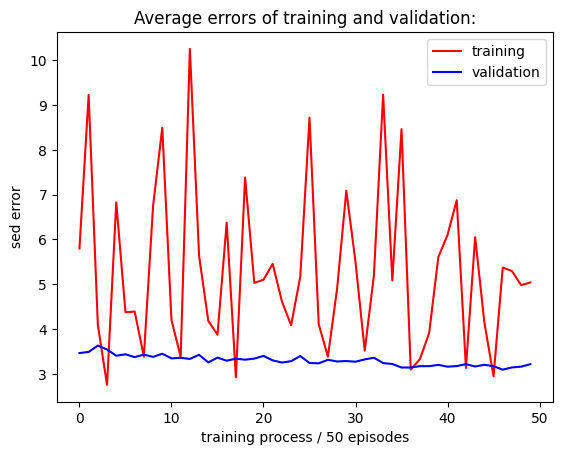

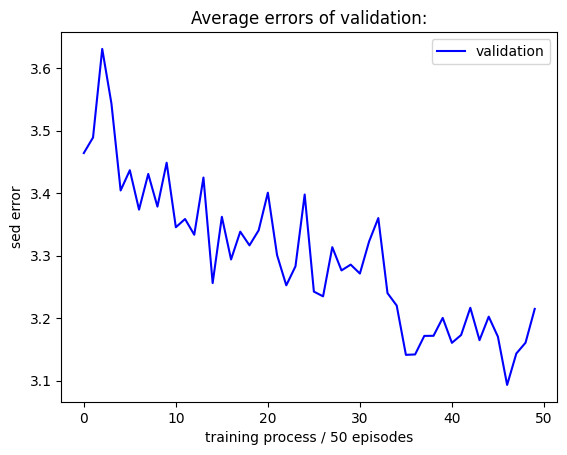

In [8]:
train(traj_amount=500, valid_amount=100, Round=5, show_time=50, ratio=0.5, a_size=3, s_size=3, label='sed')

In [24]:
import data_utils as F
set = []
for num in range(500,600):
    set.append(F.to_traj('../trajData/Geolife_out/' + str(num)))
total = 0
for ep in set:
    total += len(ep)
print(len(set))
print(total/len(set))

set = []
for num in range(17378,17678):
    set.append(F.to_traj('../trajData/Geolife_out/' + str(num)))
total = 0
for ep in set:
    total += len(ep)
print(len(set))
print(total/len(set))

ERROR! Session/line number was not unique in database. History logging moved to new session 251
100
1280.86
300
1577.7466666666667


In [1]:
import data_utils as F
total = 0
for num in range(17678):
    total += len(F.to_traj('../trajData/Geolife_out/' + str(num)))
print(total/17678)

1406.3926349134517


In [2]:
import data_utils as F
total = 0
for num in range(1000):
    total += len(F.to_traj('../trajData/Geolife_out/' + str(num)))
print(total/1000)
total = 0
for num in range(1000,2000):
    total += len(F.to_traj('../trajData/Geolife_out/' + str(num)))
print(total/1000)
total = 0
for num in range(2000,3000):
    total += len(F.to_traj('../trajData/Geolife_out/' + str(num)))
print(total/1000)

1342.356
1409.329
1502.397


1333.572


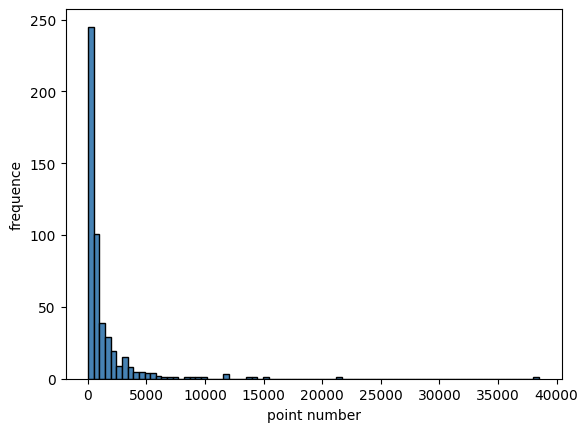

In [5]:
import data_utils as F
import matplotlib.pyplot as plt
import numpy as np
nums = []
for num in range(500):
    a = len(F.to_traj('../trajData/Geolife_out/' + str(num)))
    nums.append(a)
print(sum(nums)/len(nums))
plt.hist(x = nums, # 指定绘图数据
         bins = 80, # 指定直方图中条块的个数
         color = 'steelblue', # 指定直方图的填充色
         edgecolor = 'black', # 指定直方图的边框色
         )
plt.xlabel('point number')
plt.ylabel('frequence')
plt.show()


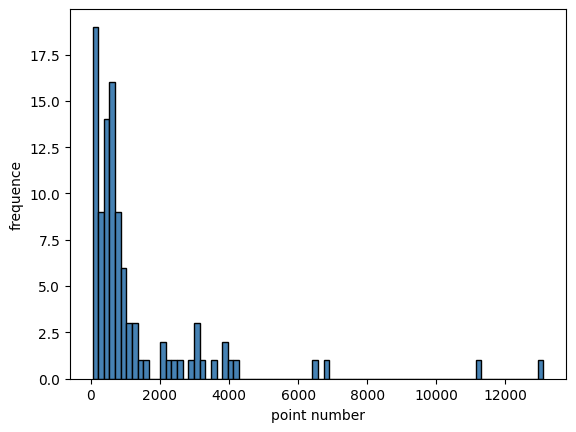

In [2]:
nums = []
for num in range(500, 600):
    a = len(F.to_traj('../trajData/Geolife_out/' + str(num)))
    nums.append(a)
plt.hist(x = nums, # 指定绘图数据
         bins = 80, # 指定直方图中条块的个数
         color = 'steelblue', # 指定直方图的填充色
         edgecolor = 'black', # 指定直方图的边框色
         )
plt.xlabel('point number')
plt.ylabel('frequence')
plt.show()

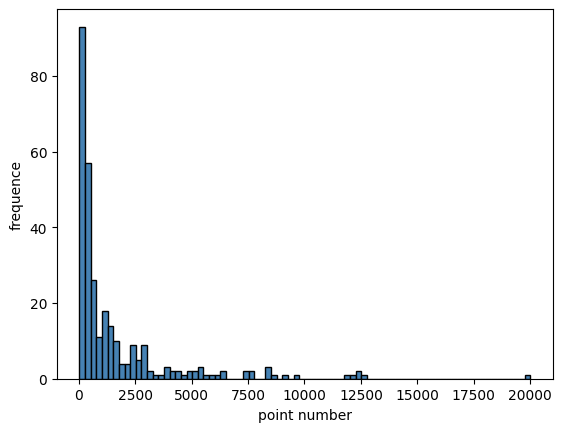

In [3]:
nums = []
for num in range(17378,17678):
    a = len(F.to_traj('../trajData/Geolife_out/' + str(num)))
    nums.append(a)
plt.hist(x = nums, # 指定绘图数据
         bins = 80, # 指定直方图中条块的个数
         color = 'steelblue', # 指定直方图的填充色
         edgecolor = 'black', # 指定直方图的边框色
         )
plt.xlabel('point number')
plt.ylabel('frequence')
plt.show()

In [10]:
import data_utils as F
total = 0
for num in range(17678):
    if len(F.to_traj('../trajData/Geolife_out/' + str(num)))>1000:
        total += 1
print(total)

5900


# evaluate

In [1]:
from rl_env_inc import TrajComp
from rl_brain import PolicyGradient
import data_utils as F
import time

def evaluate(env, RL, ratio, elist): # Evaluation
    eva = []
    for episode in elist:
        buffer_size = int(ratio*len(env.ori_traj_set[episode]))
        if buffer_size < 3:
            continue
        steps, observation = env.reset(episode, buffer_size)
        for index in range(buffer_size, steps):
            if index == steps - 1:
                done = True
            else:
                done = False
            action = RL.quick_time_action(observation)
            observation_, _ = env.step(episode, action, index, done, 'V') #'T' means Training, and 'V' means Validation
            observation = observation_
        eva.append(env.output(episode, 'V')) #'T' means Training, 'V' means Validation, and 'V-VIS' for visualization on Validation
    return sum(eva)/len(eva)

def test(model_path, amount, ratio, a_size, s_size, label):
    print("======Start testing the model at'{}======'".format(model_path))
    traj_path = '../trajData/Geolife_out/'
    env = TrajComp(a_size, s_size)
    env.load_test_data(traj_path, amount)
    env.set_error_type(label)
    rl = PolicyGradient(env.n_features, env.n_actions)
    rl.load(model_path) #your_trained_model your_trained_model_skip
    start = time.time()
    effectiveness = evaluate(env, rl, ratio, range(amount))
    print("Effectiveness: %e" %effectiveness)
    print("Training elapsed time = %s", float(time.time() - start))
    return effectiveness    

def test_one_sample(model_path, index, ratio, a_size, s_size, label):
    print("======Start testing the model at'{}======'".format(model_path))
    traj_path = '../trajData/Geolife_out/'
    env = TrajComp(a_size, s_size)
    env.load_one_sample(traj_path, index)
    env.set_error_type(label)
    rl = PolicyGradient(env.n_features, env.n_actions)
    rl.load(model_path) #your_trained_model your_trained_model_skip
    
    net_time = 0
    step_time = 0
    start_ = time.time()
    eva = []
    buffer_size = int(ratio*len(env.ori_traj_set[0]))
    if buffer_size < 3:
        return
    steps, observation = env.reset(0, buffer_size)
    for index in range(buffer_size, steps):
        if index == steps - 1:
            done = True
        else:
            done = False
        start = time.time()
        action = rl.quick_time_action(observation)
        net_time += float(time.time()-start)
        start = time.time()
        observation_, _ = env.step(0, action, index, done, 'V') #'T' means Training, and 'V' means Validation
        step_time += float(time.time()-start)
        observation = observation_
    eva=env.output(0, 'V') #'T' means Training, 'V' means Validation, and 'V-VIS' for visualization on Validation
    print("Effectiveness: %e" %eva)
    print("Training elapsed time = %s", float(time.time() - start_))
    print("net_time:",net_time)
    print("step_time:",step_time)   

def evaluate_skip(elist):
    effectiveness = []
    total_len = []
    skip_pts = 0
    step_pts = 0
    for episode in elist:
        #print('online episode', episode)
        total_len.append(len(env.ori_traj_set[episode]))
        buffer_size = int(ratio*len(env.ori_traj_set[episode]))
        if buffer_size < 3:
            continue
        steps, observation = env.reset(episode, buffer_size)
        step_pts = step_pts + steps
        for index in range(buffer_size, steps):
            if index == steps - 1:
                done = True
            else:
                done = False
            if index < env.INX:
                #print('test skip')
                skip_pts = skip_pts + 1
                continue
            action = RL.quick_time_action(observation) #matrix implementation for fast efficiency when the model is ready
            observation_, _ = env.step(episode, action, index, done, 'V') #'T' means Training, and 'V' means Validation
            observation = observation_
        effectiveness.append(env.output(episode, 'V')) #'T' means Training, 'V' means Validation, and 'V-VIS' for visualization on Validation
    return sum(effectiveness)/len(effectiveness)


## dad

In [9]:
test_one_sample(model_path='save/1.8379519265790878_ratio_0.1_dad/', index=106, ratio=0.1, a_size=3, s_size=3, label='sed')

======Start testing the model at'save/1.8379519265790878_ratio_0.1_dad/======'
training from last checkpoint save/1.8379519265790878_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save/1.8379519265790878_ratio_0.1_dad/trained_model.ckpt
Effectiveness: 1.852766e+01
Training elapsed time = %s 1.3568031787872314
net_time: 0.5182600021362305
step_time: 0.755854606628418


In [6]:
test(model_path='save/1.8379519265790878_ratio_0.1_dad/', amount=300, ratio=0.1, a_size=3, s_size=3, label='dad')

======Start testing the model at'save/1.8379519265790878_ratio_0.1_dad/======'
training from last checkpoint save/1.8379519265790878_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save/1.8379519265790878_ratio_0.1_dad/trained_model.ckpt
Effectiveness: 1.896389e+00
Training elapsed time = %s 46.71492886543274


1.8963889073810174

In [7]:
test(model_path='save/1.8379519265790878_ratio_0.1_dad/', amount=300, ratio=0.1, a_size=3, s_size=3, label='sed')

======Start testing the model at'save/1.8379519265790878_ratio_0.1_dad/======'
training from last checkpoint save/1.8379519265790878_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save/1.8379519265790878_ratio_0.1_dad/trained_model.ckpt
Effectiveness: 1.269468e+02
Training elapsed time = %s 64.6348226070404


126.94682896785535

In [8]:
test(model_path='save/1.8379519265790878_ratio_0.1_dad/', amount=300, ratio=0.1, a_size=3, s_size=3, label='ped')

======Start testing the model at'save/1.8379519265790878_ratio_0.1_dad/======'
training from last checkpoint save/1.8379519265790878_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save/1.8379519265790878_ratio_0.1_dad/trained_model.ckpt
Effectiveness: 4.145863e+01
Training elapsed time = %s 46.13323950767517


41.45862841834385

In [9]:
test(model_path='save/1.8379519265790878_ratio_0.1_dad/', amount=300, ratio=0.1, a_size=3, s_size=3, label='sad')

======Start testing the model at'save/1.8379519265790878_ratio_0.1_dad/======'
training from last checkpoint save/1.8379519265790878_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save/1.8379519265790878_ratio_0.1_dad/trained_model.ckpt
Effectiveness: 7.432840e+00
Training elapsed time = %s 109.36643648147583


7.432839853108051

In [10]:
test(model_path='save/1.8379519265790878_ratio_0.1_dad/', amount=300, ratio=0.2, a_size=3, s_size=3, label='dad')

======Start testing the model at'save/1.8379519265790878_ratio_0.1_dad/======'
training from last checkpoint save/1.8379519265790878_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save/1.8379519265790878_ratio_0.1_dad/trained_model.ckpt
Effectiveness: 1.081923e+00
Training elapsed time = %s 43.76492261886597


1.0819230379935447

In [11]:
test(model_path='save/1.8379519265790878_ratio_0.1_dad/', amount=300, ratio=0.3, a_size=3, s_size=3, label='dad')

======Start testing the model at'save/1.8379519265790878_ratio_0.1_dad/======'
training from last checkpoint save/1.8379519265790878_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save/1.8379519265790878_ratio_0.1_dad/trained_model.ckpt
Effectiveness: 6.415240e-01
Training elapsed time = %s 39.83200240135193


0.6415240358513159

In [12]:
test(model_path='save/1.8379519265790878_ratio_0.1_dad/', amount=300, ratio=0.4, a_size=3, s_size=3, label='dad')

======Start testing the model at'save/1.8379519265790878_ratio_0.1_dad/======'
training from last checkpoint save/1.8379519265790878_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save/1.8379519265790878_ratio_0.1_dad/trained_model.ckpt
Effectiveness: 4.173001e-01
Training elapsed time = %s 35.71012759208679


0.41730008217698467

In [13]:
test(model_path='save/1.8379519265790878_ratio_0.1_dad/', amount=300, ratio=0.5, a_size=3, s_size=3, label='dad')

======Start testing the model at'save/1.8379519265790878_ratio_0.1_dad/======'
training from last checkpoint save/1.8379519265790878_ratio_0.1_dad/
INFO:tensorflow:Restoring parameters from save/1.8379519265790878_ratio_0.1_dad/trained_model.ckpt
Effectiveness: 2.703424e-01
Training elapsed time = %s 30.320857048034668


0.27034243999252594

## sad

In [7]:
test(model_path='save/6.71273141708931_ratio_0.1_sad/', amount=300, ratio=0.1, a_size=3, s_size=3, label='sad')

======Start testing the model at'save/6.71273141708931_ratio_0.1_sad/======'
training from last checkpoint save/6.71273141708931_ratio_0.1_sad/
INFO:tensorflow:Restoring parameters from save/6.71273141708931_ratio_0.1_sad/trained_model.ckpt


INFO:tensorflow:Restoring parameters from save/6.71273141708931_ratio_0.1_sad/trained_model.ckpt


Effectiveness: 7.674915e+00
Training elapsed time = %s 109.12847685813904


7.674915133340574

In [8]:
test(model_path='save/6.71273141708931_ratio_0.1_sad/', amount=300, ratio=0.2, a_size=3, s_size=3, label='sad')

======Start testing the model at'save/6.71273141708931_ratio_0.1_sad/======'
training from last checkpoint save/6.71273141708931_ratio_0.1_sad/
INFO:tensorflow:Restoring parameters from save/6.71273141708931_ratio_0.1_sad/trained_model.ckpt


INFO:tensorflow:Restoring parameters from save/6.71273141708931_ratio_0.1_sad/trained_model.ckpt


Effectiveness: 3.787236e+00
Training elapsed time = %s 101.85812330245972


3.787235532701524

In [9]:
test(model_path='save/6.71273141708931_ratio_0.1_sad/', amount=300, ratio=0.3, a_size=3, s_size=3, label='sad')

======Start testing the model at'save/6.71273141708931_ratio_0.1_sad/======'
training from last checkpoint save/6.71273141708931_ratio_0.1_sad/
INFO:tensorflow:Restoring parameters from save/6.71273141708931_ratio_0.1_sad/trained_model.ckpt


INFO:tensorflow:Restoring parameters from save/6.71273141708931_ratio_0.1_sad/trained_model.ckpt


Effectiveness: 2.474755e+00
Training elapsed time = %s 93.29799270629883


2.474754841210004

In [10]:
test(model_path='save/6.71273141708931_ratio_0.1_sad/', amount=300, ratio=0.4, a_size=3, s_size=3, label='sad')

======Start testing the model at'save/6.71273141708931_ratio_0.1_sad/======'
training from last checkpoint save/6.71273141708931_ratio_0.1_sad/
INFO:tensorflow:Restoring parameters from save/6.71273141708931_ratio_0.1_sad/trained_model.ckpt


INFO:tensorflow:Restoring parameters from save/6.71273141708931_ratio_0.1_sad/trained_model.ckpt


Effectiveness: 1.759241e+00
Training elapsed time = %s 83.56575417518616


1.7592413934886861

In [11]:
test(model_path='save/6.71273141708931_ratio_0.1_sad/', amount=300, ratio=0.5, a_size=3, s_size=3, label='sad')

======Start testing the model at'save/6.71273141708931_ratio_0.1_sad/======'
training from last checkpoint save/6.71273141708931_ratio_0.1_sad/
INFO:tensorflow:Restoring parameters from save/6.71273141708931_ratio_0.1_sad/trained_model.ckpt


INFO:tensorflow:Restoring parameters from save/6.71273141708931_ratio_0.1_sad/trained_model.ckpt


Effectiveness: 1.297253e+00
Training elapsed time = %s 76.29723834991455


1.2972527704549885

In [12]:
test(model_path='save/6.71273141708931_ratio_0.1_sad/', amount=300, ratio=0.1, a_size=3, s_size=3, label='sed')

======Start testing the model at'save/6.71273141708931_ratio_0.1_sad/======'
training from last checkpoint save/6.71273141708931_ratio_0.1_sad/
INFO:tensorflow:Restoring parameters from save/6.71273141708931_ratio_0.1_sad/trained_model.ckpt


INFO:tensorflow:Restoring parameters from save/6.71273141708931_ratio_0.1_sad/trained_model.ckpt


Effectiveness: 1.289616e+02
Training elapsed time = %s 64.18546319007874


128.9616206502359

In [13]:
test(model_path='save/6.71273141708931_ratio_0.1_sad/', amount=300, ratio=0.1, a_size=3, s_size=3, label='ped')

======Start testing the model at'save/6.71273141708931_ratio_0.1_sad/======'
training from last checkpoint save/6.71273141708931_ratio_0.1_sad/
INFO:tensorflow:Restoring parameters from save/6.71273141708931_ratio_0.1_sad/trained_model.ckpt


INFO:tensorflow:Restoring parameters from save/6.71273141708931_ratio_0.1_sad/trained_model.ckpt


Effectiveness: 4.427690e+01
Training elapsed time = %s 46.97338318824768


44.276902705679845

In [14]:
test(model_path='save/6.71273141708931_ratio_0.1_sad/', amount=300, ratio=0.1, a_size=3, s_size=3, label='dad')

======Start testing the model at'save/6.71273141708931_ratio_0.1_sad/======'
training from last checkpoint save/6.71273141708931_ratio_0.1_sad/
INFO:tensorflow:Restoring parameters from save/6.71273141708931_ratio_0.1_sad/trained_model.ckpt


INFO:tensorflow:Restoring parameters from save/6.71273141708931_ratio_0.1_sad/trained_model.ckpt


Effectiveness: 1.912863e+00
Training elapsed time = %s 46.94707632064819


1.9128631008661197

## ped

In [15]:
test(model_path='save/17.57928306848788_ratio_0.1_ped/', amount=300, ratio=0.1, a_size=3, s_size=3, label='ped')

======Start testing the model at'save/17.57928306848788_ratio_0.1_ped/======'
training from last checkpoint save/17.57928306848788_ratio_0.1_ped/
INFO:tensorflow:Restoring parameters from save/17.57928306848788_ratio_0.1_ped/trained_model.ckpt


INFO:tensorflow:Restoring parameters from save/17.57928306848788_ratio_0.1_ped/trained_model.ckpt


Effectiveness: 2.923345e+01
Training elapsed time = %s 44.91606783866882


29.233447322225164

In [16]:
test(model_path='save/17.57928306848788_ratio_0.1_ped/', amount=300, ratio=0.2, a_size=3, s_size=3, label='ped')

======Start testing the model at'save/17.57928306848788_ratio_0.1_ped/======'
training from last checkpoint save/17.57928306848788_ratio_0.1_ped/
INFO:tensorflow:Restoring parameters from save/17.57928306848788_ratio_0.1_ped/trained_model.ckpt


INFO:tensorflow:Restoring parameters from save/17.57928306848788_ratio_0.1_ped/trained_model.ckpt


Effectiveness: 9.871220e+00
Training elapsed time = %s 45.54092264175415


9.871220417632905

In [18]:
test(model_path='save/17.57928306848788_ratio_0.1_ped/', amount=300, ratio=0.3, a_size=3, s_size=3, label='ped')

======Start testing the model at'save/17.57928306848788_ratio_0.1_ped/======'
training from last checkpoint save/17.57928306848788_ratio_0.1_ped/
INFO:tensorflow:Restoring parameters from save/17.57928306848788_ratio_0.1_ped/trained_model.ckpt


INFO:tensorflow:Restoring parameters from save/17.57928306848788_ratio_0.1_ped/trained_model.ckpt


Effectiveness: 4.936299e+00
Training elapsed time = %s 39.83397459983826


4.936299189702654

In [19]:
test(model_path='save/17.57928306848788_ratio_0.1_ped/', amount=300, ratio=0.4, a_size=3, s_size=3, label='ped')

======Start testing the model at'save/17.57928306848788_ratio_0.1_ped/======'
training from last checkpoint save/17.57928306848788_ratio_0.1_ped/
INFO:tensorflow:Restoring parameters from save/17.57928306848788_ratio_0.1_ped/trained_model.ckpt


INFO:tensorflow:Restoring parameters from save/17.57928306848788_ratio_0.1_ped/trained_model.ckpt


Effectiveness: 3.028918e+00
Training elapsed time = %s 34.800211668014526


3.0289177446258693

In [20]:
test(model_path='save/17.57928306848788_ratio_0.1_ped/', amount=300, ratio=0.5, a_size=3, s_size=3, label='ped')

======Start testing the model at'save/17.57928306848788_ratio_0.1_ped/======'
training from last checkpoint save/17.57928306848788_ratio_0.1_ped/
INFO:tensorflow:Restoring parameters from save/17.57928306848788_ratio_0.1_ped/trained_model.ckpt


INFO:tensorflow:Restoring parameters from save/17.57928306848788_ratio_0.1_ped/trained_model.ckpt


Effectiveness: 1.919906e+00
Training elapsed time = %s 29.391144275665283


1.9199062707477288

In [21]:
test(model_path='save/17.57928306848788_ratio_0.1_ped/', amount=300, ratio=0.1, a_size=3, s_size=3, label='sed')

======Start testing the model at'save/17.57928306848788_ratio_0.1_ped/======'
training from last checkpoint save/17.57928306848788_ratio_0.1_ped/
INFO:tensorflow:Restoring parameters from save/17.57928306848788_ratio_0.1_ped/trained_model.ckpt


INFO:tensorflow:Restoring parameters from save/17.57928306848788_ratio_0.1_ped/trained_model.ckpt


Effectiveness: 7.286864e+01
Training elapsed time = %s 60.78257441520691


72.86863813691228

In [22]:
test(model_path='save/17.57928306848788_ratio_0.1_ped/', amount=300, ratio=0.1, a_size=3, s_size=3, label='dad')

======Start testing the model at'save/17.57928306848788_ratio_0.1_ped/======'
training from last checkpoint save/17.57928306848788_ratio_0.1_ped/
INFO:tensorflow:Restoring parameters from save/17.57928306848788_ratio_0.1_ped/trained_model.ckpt


INFO:tensorflow:Restoring parameters from save/17.57928306848788_ratio_0.1_ped/trained_model.ckpt


Effectiveness: 1.872669e+00
Training elapsed time = %s 45.93737816810608


1.8726687134625213

In [23]:
test(model_path='save/17.57928306848788_ratio_0.1_ped/', amount=300, ratio=0.1, a_size=3, s_size=3, label='sad')

======Start testing the model at'save/17.57928306848788_ratio_0.1_ped/======'
training from last checkpoint save/17.57928306848788_ratio_0.1_ped/
INFO:tensorflow:Restoring parameters from save/17.57928306848788_ratio_0.1_ped/trained_model.ckpt


INFO:tensorflow:Restoring parameters from save/17.57928306848788_ratio_0.1_ped/trained_model.ckpt


Effectiveness: 7.045368e+00
Training elapsed time = %s 104.78582882881165


7.045367967254376